# Mandelbrot in Mojo with Python plots


Not only is Mojo great for writing high-performance code, but it also allows us to leverage the huge Python ecosystem of libraries and tools. With seamless Python interoperability, Mojo can use Python for what it's good at, especially GUIs, without sacrificing performance in critical code. Let's take the classic Mandelbrot set algorithm and implement it in Mojo.

This tutorial shows two aspects of Mojo. First, it shows that Mojo can be used to develop fast programs for irregular applications. It also shows how we can leverage Python for visualizing the results.

In [1]:
#|code-fold: true
from benchmark import Unit, run
from complex import ComplexSIMD, ComplexFloat64
from math import iota
from python import Python
from runtime.llcl import num_cores
from algorithm import parallelize, vectorize
from tensor import Tensor
from utils.index import Index

alias float_type = DType.float64
alias simd_width = 2 * simdwidthof[float_type]()

First set some parameters, you can try changing these to see different results:

In [2]:
alias width = 1024
alias height = 1024
alias MAX_ITERS = 200

alias min_x = -2.0
alias max_x = 0.6
alias min_y = -1.5
alias max_y = 1.5


The core [Mandelbrot](https://en.wikipedia.org/wiki/Mandelbrot_set) algorithm involves computing an iterative complex function for each pixel until it "escapes" the complex circle of radius 2, counting the number of iterations to escape:

$$z_{i+1} = z_i^2 + c$$

In [3]:
# Compute the number of steps to escape.
def mandelbrot_kernel(c: ComplexFloat64) -> Int:
    z = c
    for i in range(MAX_ITERS):
        z = z * z + c
        if z.squared_norm() > 4:
            return i
    return MAX_ITERS


def compute_mandelbrot() -> Tensor[float_type]:
    # create a matrix. Each element of the matrix corresponds to a pixel
    t = Tensor[float_type](height, width)

    dx = (max_x - min_x) / width
    dy = (max_y - min_y) / height

    y = min_y
    for row in range(height):
        x = min_x
        for col in range(width):
            t[Index(row, col)] = mandelbrot_kernel(ComplexFloat64(x, y))
            x += dx
        y += dy
    return t

Plotting the number of iterations to escape with some color gives us the canonical Mandelbrot set plot. To render it we can directly leverage Python's `matplotlib` right from Mojo!

First install the required libraries:

In [4]:
%%python
from importlib.util import find_spec
import shutil
import subprocess

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path")
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found")

install_if_missing("numpy")
install_if_missing("matplotlib")

Execution time for compute_mandelbrot:  153 ms


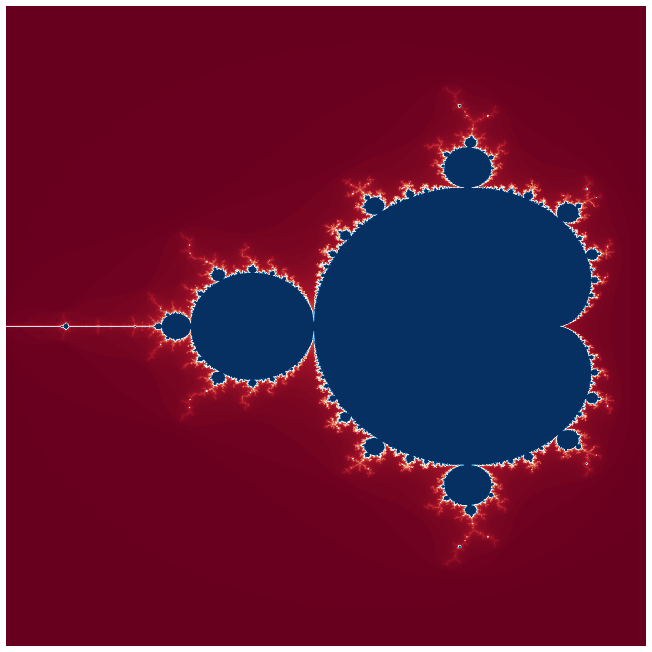

In [5]:
def show_plot(tensor: Tensor[float_type]):

    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")

    numpy_array = np.zeros((height, width), np.float64)

    for row in range(height):
        for col in range(width):
            numpy_array.itemset((col, row), tensor[col, row])
            
    
    fig = plt.figure(1, [10, 10 * height // width], 64)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)
    plt.imshow(numpy_array, 'RdBu')
    plt.axis("off")
    plt.show()
 

let eval_begin: Int = time.now()
let out = compute_mandelbrot()
let eval_end: Int = time.now()
let execution_time = (eval_end - eval_begin) // 1000000  # Convert to milliseconds
print('Execution time for compute_mandelbrot: ', execution_time, 'ms')

show_plot(out)

## Vectorizing Mandelbrot
We showed a naive implementation of the Mandelbrot algorithm, but there are two things we can do to speed it up. We can early-stop the loop iteration when a pixel is known to have escaped, and we can leverage Mojo's access to hardware by vectorizing the loop, computing multiple pixels simultaneously. To do that we will use the `vectorize` higher order generator.

We start by defining our main iteration loop in a vectorized fashion

In [6]:
fn mandelbrot_kernel_SIMD[
    simd_width: Int
](c: ComplexSIMD[float_type, simd_width]) -> SIMD[float_type, simd_width]:
    """A vectorized implementation of the inner mandelbrot computation."""
    let cx = c.re
    let cy = c.im
    var x = SIMD[float_type, simd_width](0)
    var y = SIMD[float_type, simd_width](0)
    var y2 = SIMD[float_type, simd_width](0)
    var iters = SIMD[float_type, simd_width](0)

    var t: SIMD[DType.bool, simd_width] = True
    for i in range(MAX_ITERS):
        if not t.reduce_or():
            break
        y2 = y*y
        y = x.fma(y + y, cy)
        t = x.fma(x, y2) <= 4
        x = x.fma(x, cx - y2)
        iters = t.select(iters + 1, iters)
    return iters

The above function is parameterized on the `simd_width` and processes simd_width pixels. It only escapes once all pixels within the vector lane are done. We can use the same iteration loop as above, but this time we vectorize within each row instead. We use the `vectorize` generator to make this a simple function call.

Vectorized : 38.904499999999999 ms


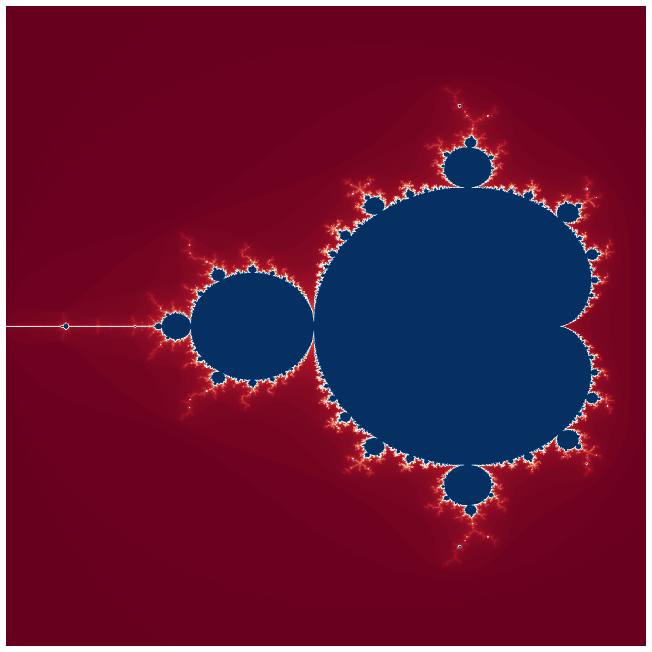

In [7]:
fn vectorized():
    let t = Tensor[float_type](height, width)

    @parameter
    fn worker(row: Int):
        let scale_x = (max_x - min_x) / width
        let scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we oeprate on a `simd_width` vector of pixels."""
            let cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            let cy = min_y + row * scale_y
            let c = ComplexSIMD[float_type, simd_width](cx, cy)
            t.data().simd_store[simd_width](
                row * width + col, mandelbrot_kernel_SIMD[simd_width](c)
            )

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[simd_width, compute_vector](width)

    @parameter
    fn bench[simd_width: Int]():
        for row in range(height):
            worker(row)

    let vectorized = benchmark.run[bench[simd_width]](
        max_runtime_secs=0.5
    ).mean(Unit.ms)

    print("Vectorized", ":", vectorized, "ms")

    try:
        _ = show_plot(t)
    except e:
        print("failed to show plot:", e)

vectorized()

## Parallelizing Mandelbrot
While the vectorized implementation above is efficient, we can get better performance by parallelizing on the cols. This again is simple in Mojo using the `parallelize` higher order function. Only the function that performs the invocation needs to change.

Parallelized: 7.5025300000000001 ms


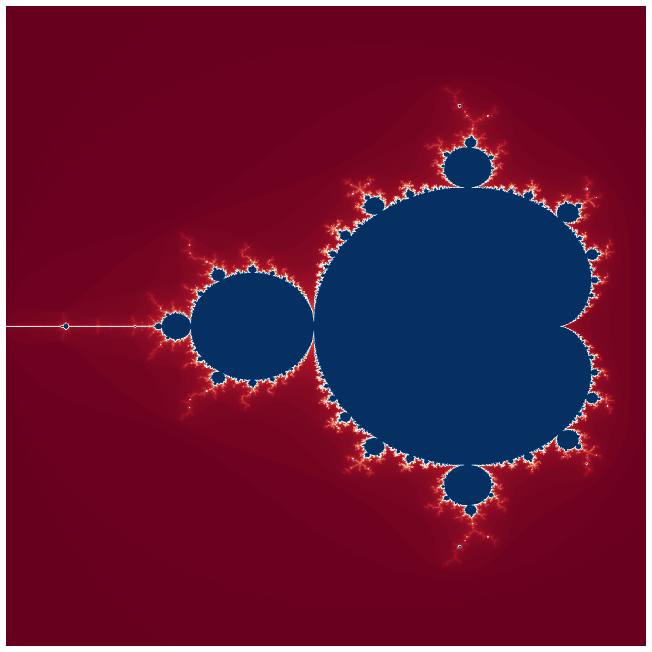

In [8]:
fn parallelized():
    let t = Tensor[float_type](height, width)
    
    @parameter
    fn worker(row: Int):
        let scale_x = (max_x - min_x) / width
        let scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we oeprate on a `simd_width` vector of pixels."""
            let cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            let cy = min_y + row * scale_y
            let c = ComplexSIMD[float_type, simd_width](cx, cy)
            t.data().simd_store[simd_width](row * width + col, mandelbrot_kernel_SIMD[simd_width](c))

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[simd_width, compute_vector](width)


    @parameter
    fn bench_parallel[simd_width: Int]():
        parallelize[worker](height, height)

    let parallelized = benchmark.run[bench_parallel[simd_width]](
        max_runtime_secs=0.5
    ).mean(Unit.ms)

    print("Parallelized:", parallelized, Unit.ms)

    try:
        _ = show_plot(t)
    except e:
        print("failed to show plot:", e)

parallelized()

## Benchmarking

In this section we increase the size to 4096x4096 and run 1000 iterations for a larger test to stress the CPU 

In [9]:
fn compare():
    let t = Tensor[float_type](height, width)
    
    @parameter
    fn worker(row: Int):
        let scale_x = (max_x - min_x) / width
        let scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we oeprate on a `simd_width` vector of pixels."""
            let cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            let cy = min_y + row * scale_y
            let c = ComplexSIMD[float_type, simd_width](cx, cy)
            t.data().simd_store[simd_width](
                row * width + col, mandelbrot_kernel_SIMD[simd_width](c)
            )

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[simd_width, compute_vector](width)

    @parameter
    fn bench[simd_width: Int]():
        for row in range(height):
            worker(row)

    let vectorized = benchmark.run[bench[simd_width]](
        max_runtime_secs=0.5
    ).mean(Unit.ms)
    print("Number of threads:", num_cores())
    print("Vectorized:", vectorized, "ms")

    # Parallelized
    @parameter
    fn bench_parallel[simd_width: Int]():
        parallelize[worker](height, height)

    let parallelized = benchmark.run[bench_parallel[simd_width]](
        max_runtime_secs=0.5
    ).mean(Unit.ms)
    print("Parallelized:", parallelized, "ms")
    print("Parallel speedup:", vectorized / parallelized)

    _ = t # Make sure tensor isn't destroyed before benchmark is finished

In [10]:
let eval_begin: Int = time.now()
_ = compute_mandelbrot()
let eval_end: Int = time.now()
let execution_time = (eval_end - eval_begin) // 1000000  # Convert
print('Naive: ', execution_time, 'ms')
compare()

Naive:  150 ms
Number of threads: 8
Vectorized: 38.752899999999997 ms
Parallelized: 6.6880100000000002 ms
Parallel speedup: 5.7943842787316404
